## FLIGHT STATUS PREDICTOR PROJECT


##### The goal of this project is to develop and deploy an ML model in which an end user can specify a set of features describing a commercial flight of interest and receive a categorical (yes or no) output indicating if the arrival time of that flight will be delayed more than fifteen minutes or not. 


### CLEANING, FORMATING & EDA

In [4]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
# Import dataset
df = pd.read_csv('downsampled_data_updated.csv')

In [6]:
# Check dataframe
df.head()

,Carrier_Name,Month_Day,Week_Day,Flight_Date,Airline_DOT_ID,Tail_Number,Flight_Number,Origin_Airport_ID,Origin_City_Market_ID,Origin_IATA_Code,...,Dep_Delay_At_Least_15_Minutes,Scheduled_Arrival_Time,Arr_Time_Block_Group,Arr_Delay_At_Least_15_Minutes,Flight_Cancelled,Flight_Diverted,Scheduled_Gate_to_Gate_Time,Number_of_Flights,Distance_Miles,Distance_Group
0,Spirit Air Lines,13,Saturday,2023-05-13,20416,N665NK,1201,14730,33044,SDF,...,0,703,Early Morning,0,0,0,243,1,1624,7
1,Southwest Airlines Co.,22,Monday,2023-05-22,19393,N8650F,2347,14107,30466,PHX,...,0,125,Early Morning,0,0,0,145,1,1044,5
2,Southwest Airlines Co.,17,Wednesday,2023-05-17,19393,N249WN,246,11193,33105,CVG,...,0,1430,Early Afternoon,0,0,0,85,1,430,2
3,Delta Air Lines Inc.,18,Sunday,2023-06-18,19790,N324DX,1127,10721,30721,BOS,...,0,1720,Afternoon,0,0,0,195,1,1124,5
4,United Air Lines Inc.,9,Friday,2023-06-09,19977,N26208,473,13930,30977,ORD,...,0,100,Early Morning,0,0,0,153,1,867,4


In [7]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2742902 entries, 0 to 2742901
Data columns (total 27 columns):
 #   Column                         Dtype 
---  ------                         ----- 
 0   Carrier_Name                   object
 1   Month_Day                      int64 
 2   Week_Day                       object
 3   Flight_Date                    object
 4   Airline_DOT_ID                 int64 
 5   Tail_Number                    object
 6   Flight_Number                  int64 
 7   Origin_Airport_ID              int64 
 8   Origin_City_Market_ID          int64 
 9   Origin_IATA_Code               object
 10  Origin_City_State              object
 11  Destination_Airport_ID         int64 
 12  Destination_City_Market_ID     int64 
 13  Destination_IATA_Code          object
 14  Destination_City_State         object
 15  Dep_Time_Block_Group           object
 16  Scheduled_Departure_Time       int64 
 17  Dep_Delay_At_Least_15_Minutes  int64 
 18  Scheduled_Arrival_Time

In [8]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Carrier_Name                     0
Month_Day                        0
Week_Day                         0
Flight_Date                      0
Airline_DOT_ID                   0
Tail_Number                      0
Flight_Number                    0
Origin_Airport_ID                0
Origin_City_Market_ID            0
Origin_IATA_Code                 0
Origin_City_State                0
Destination_Airport_ID           0
Destination_City_Market_ID       0
Destination_IATA_Code            0
Destination_City_State           0
Dep_Time_Block_Group             0
Scheduled_Departure_Time         0
Dep_Delay_At_Least_15_Minutes    0
Scheduled_Arrival_Time           0
Arr_Time_Block_Group             0
Arr_Delay_At_Least_15_Minutes    0
Flight_Cancelled                 0
Flight_Diverted                  0
Scheduled_Gate_to_Gate_Time      0
Number_of_Flights                0
Distance_Miles                   0
Distance_Group                   0
dtype: int64


In [9]:
# Handle missing values
# Remove columns with more than 50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

In [10]:
# Impute remaining missing values with mean for numerical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

In [11]:
# Check for duplicates
df = df.drop_duplicates()

In [12]:
# Feature Engineering
# Extract new features from existing feature 'Flight_Date' 
df['Date'] = pd.to_datetime(df['Flight_Date'])
df['Month'] = df['Date'].dt.month
df['Week_Day'] = df['Date'].dt.weekday
df['Day_of_Month'] = df['Date'].dt.day
df['Is_Weekend'] = df['Week_Day'].apply(lambda x: 1 if x >= 5 else 0)

# Parsing time columns
# use function to parse mixed time formats
def parse_time(time_str):
    try:
        # If time is in HH:MM format
        return pd.to_datetime(time_str, format='%H:%M').hour
    except ValueError:
        try:
            # If time is in HHMM format
            return pd.to_datetime(time_str, format='%H%M').hour
        except ValueError:
            try:
                # If time is in minutes
                return (pd.to_timedelta(int(time_str), unit='m') + pd.Timestamp('00:00')).hour
            except ValueError:
                # If parsing fails, return NaN
                return np.nan

# Apply the custom function to parse the time columns
df['Dep_Hour'] = df['Scheduled_Departure_Time'].apply(parse_time)
df['Arr_Hour'] = df['Scheduled_Arrival_Time'].apply(parse_time)

# Verify the new features
print(df[['Scheduled_Departure_Time', 'Dep_Hour', 'Scheduled_Arrival_Time', 'Arr_Hour']].head())

   Scheduled_Departure_Time  Dep_Hour  Scheduled_Arrival_Time  Arr_Hour
0                       600         6                     703         7
1                      2100        21                     125        12
2                      1305        13                    1430        14
3                      1505        15                    1720        17
4                      2127        21                     100        10


In [13]:
# Handle missing values that may arise from 'coerce' in date parsing
df.fillna(0, inplace=True)

In [14]:
# Try feature interaction
df['Dep_Time_Day_Interaction'] = df['Scheduled_Departure_Time'] * df['Week_Day']
print(df['Dep_Time_Day_Interaction'])

0          3000
1             0
2          2610
3          9030
4          8508
           ... 
2742897    5124
2742898    5850
2742899    3369
2742900    4590
2742901    2920
Name: Dep_Time_Day_Interaction, Length: 2742902, dtype: int64


In [15]:
# Check columns to identify the target variable, columns to drop and features to keep for modeling
print("Initial columns in the DataFrame:")
print(df.columns)

Initial columns in the DataFrame:
Index(['Carrier_Name', 'Month_Day', 'Week_Day', 'Flight_Date',
       'Airline_DOT_ID', 'Tail_Number', 'Flight_Number', 'Origin_Airport_ID',
       'Origin_City_Market_ID', 'Origin_IATA_Code', 'Origin_City_State',
       'Destination_Airport_ID', 'Destination_City_Market_ID',
       'Destination_IATA_Code', 'Destination_City_State',
       'Dep_Time_Block_Group', 'Scheduled_Departure_Time',
       'Dep_Delay_At_Least_15_Minutes', 'Scheduled_Arrival_Time',
       'Arr_Time_Block_Group', 'Arr_Delay_At_Least_15_Minutes',
       'Flight_Cancelled', 'Flight_Diverted', 'Scheduled_Gate_to_Gate_Time',
       'Number_of_Flights', 'Distance_Miles', 'Distance_Group', 'Date',
       'Month', 'Day_of_Month', 'Is_Weekend', 'Dep_Hour', 'Arr_Hour',
       'Dep_Time_Day_Interaction'],
      dtype='object')


In [16]:
# Define the target variable and features
target = 'Arr_Delay_At_Least_15_Minutes'
features = df.columns.tolist()
features.remove(target)

In [17]:
# Identify columns to drop to prevent information leakage & the irrelevant ones
columns_to_drop = ['Dep_Delay_At_Least_15_Minutes', 'Arr_Time_Block_Group', 'Dep_Time_Block_Group', 'Airline_DOT_ID', 'Tail_Number', 'Flight_Number',
                  'Origin_City_Market_ID', 'Origin_IATA_Code', 'Destination_City_Market_ID', 'Destination_IATA_Code', 'Flight_Cancelled', 
                  'Flight_Diverted']                  

# Drop the columns using set operations
df = df[df.columns.difference(columns_to_drop)]

# Verify the remaining columns
print("Remaining columns after dropping potential leakage columns:")
print(df.columns)

Remaining columns after dropping potential leakage columns:
Index(['Arr_Delay_At_Least_15_Minutes', 'Arr_Hour', 'Carrier_Name', 'Date',
       'Day_of_Month', 'Dep_Hour', 'Dep_Time_Day_Interaction',
       'Destination_Airport_ID', 'Destination_City_State', 'Distance_Group',
       'Distance_Miles', 'Flight_Date', 'Is_Weekend', 'Month', 'Month_Day',
       'Number_of_Flights', 'Origin_Airport_ID', 'Origin_City_State',
       'Scheduled_Arrival_Time', 'Scheduled_Departure_Time',
       'Scheduled_Gate_to_Gate_Time', 'Week_Day'],
      dtype='object')


In [18]:
# Define features (excluding target and dropped columns)
features = df.columns.tolist()
features.remove(target)

# Verify features list
print("Features to be used for model training:")
print(features)

# Split data into features and target variables
X = df[features]
y = df[target]

# Ensure y matches the index after dataset modifications
y = y.loc[X.index]

# Check changes
print("Features:", X.columns)
print("Target:", y.name)

Features to be used for model training:
['Arr_Hour', 'Carrier_Name', 'Date', 'Day_of_Month', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Destination_Airport_ID', 'Destination_City_State', 'Distance_Group', 'Distance_Miles', 'Flight_Date', 'Is_Weekend', 'Month', 'Month_Day', 'Number_of_Flights', 'Origin_Airport_ID', 'Origin_City_State', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Scheduled_Gate_to_Gate_Time', 'Week_Day']
Features: Index(['Arr_Hour', 'Carrier_Name', 'Date', 'Day_of_Month', 'Dep_Hour',
       'Dep_Time_Day_Interaction', 'Destination_Airport_ID',
       'Destination_City_State', 'Distance_Group', 'Distance_Miles',
       'Flight_Date', 'Is_Weekend', 'Month', 'Month_Day', 'Number_of_Flights',
       'Origin_Airport_ID', 'Origin_City_State', 'Scheduled_Arrival_Time',
       'Scheduled_Departure_Time', 'Scheduled_Gate_to_Gate_Time', 'Week_Day'],
      dtype='object')
Target: Arr_Delay_At_Least_15_Minutes


In [19]:
# Get data types of each column
data_types = X.dtypes

# Initialize lists to hold the names of categorical and numerical variables
categorical_vars = []
numerical_vars = []

# Identify numerical and categorical variables based on their data types
for column, dtype in data_types.items():
    if pd.api.types.is_numeric_dtype(dtype):
        numerical_vars.append(column)
    else:
        categorical_vars.append(column)

# Print the identified variables
print("Numerical Variables:")
print(numerical_vars)

print("Categorical Variables:")
print(categorical_vars)

Numerical Variables:
['Arr_Hour', 'Day_of_Month', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Destination_Airport_ID', 'Distance_Group', 'Distance_Miles', 'Is_Weekend', 'Month', 'Month_Day', 'Number_of_Flights', 'Origin_Airport_ID', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Scheduled_Gate_to_Gate_Time', 'Week_Day']
Categorical Variables:
['Carrier_Name', 'Date', 'Destination_City_State', 'Flight_Date', 'Origin_City_State']


### EXPLORATORY DATA ANALYSIS 

Class distribution:
Arr_Delay_At_Least_15_Minutes
0    1371451
1    1371451
Name: count, dtype: int64

Class distribution (percentages):
Arr_Delay_At_Least_15_Minutes
0    50.0
1    50.0
Name: proportion, dtype: float64


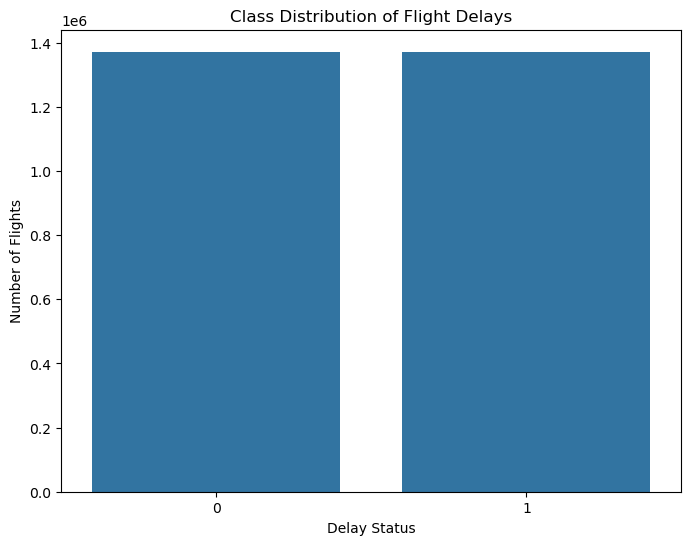

In [21]:
# Visualize the flight delays distribution
# Count the number of instances in each class
class_counts = df[target].value_counts()
print("Class distribution:")
print(class_counts)

# Calculate the percentage of each class
class_percentages = df[target].value_counts(normalize=True) * 100
print("\nClass distribution (percentages):")
print(class_percentages)

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=target, data=df)
plt.title("Class Distribution of Flight Delays")
plt.xlabel("Delay Status")
plt.ylabel("Number of Flights")
plt.show()

In [22]:
# Check skewness for each numerical variable
skewness = df[numerical_vars].skew()
print(f'Skewness of numerical variables: \n{skewness}\n')

# Apply transformations if needed
for feature in numerical_vars:
    if skewness[feature] > 0.75:
        df[feature] = np.log1p(df[feature])
        print(f'Applied log transformation to {feature}')
    elif skewness[feature] < -0.75:
        df[feature] = np.log1p(-df[feature] + df[feature].max() + 1)
        print(f'Applied log transformation to {feature}')

Skewness of numerical variables: 
Arr_Hour                      -0.346458
Day_of_Month                  -0.011654
Dep_Hour                      -0.040115
Dep_Time_Day_Interaction       0.638463
Destination_Airport_ID         0.104821
Distance_Group                 1.189954
Distance_Miles                 1.428838
Is_Weekend                     0.951453
Month                          0.008750
Month_Day                     -0.011654
Number_of_Flights              0.000000
Origin_Airport_ID              0.125396
Scheduled_Arrival_Time        -0.496694
Scheduled_Departure_Time      -0.067867
Scheduled_Gate_to_Gate_Time    1.373771
Week_Day                      -0.036221
dtype: float64

Applied log transformation to Distance_Group
Applied log transformation to Distance_Miles
Applied log transformation to Is_Weekend
Applied log transformation to Scheduled_Gate_to_Gate_Time


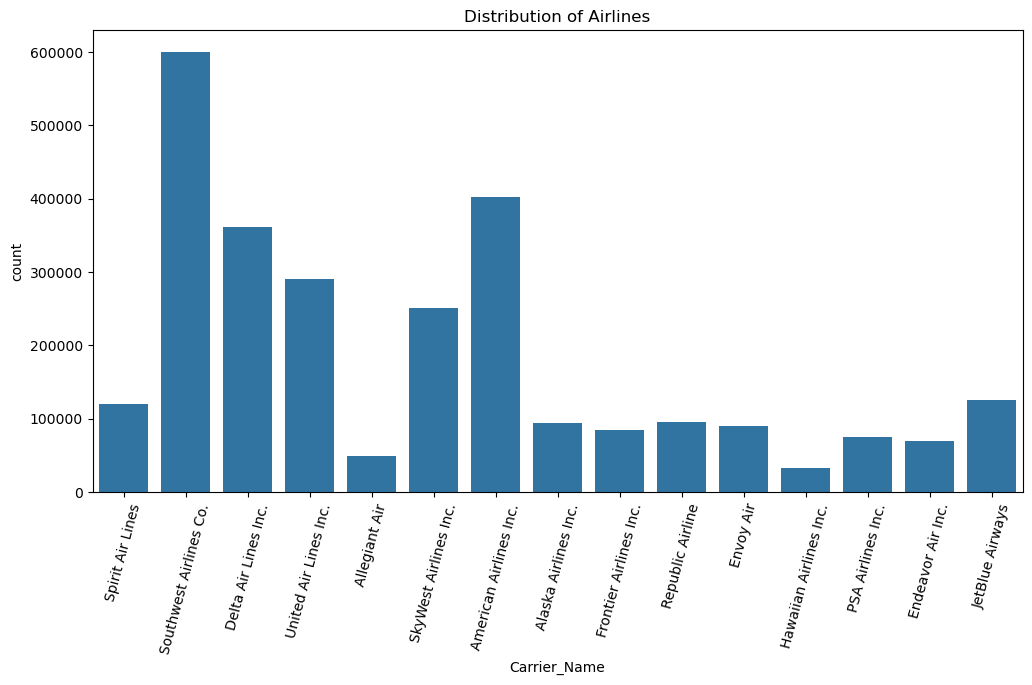

In [23]:
# Visualize the distribution of the Airlines
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Carrier_Name')
plt.title('Distribution of Airlines')
plt.xticks(rotation=75)
plt.show()

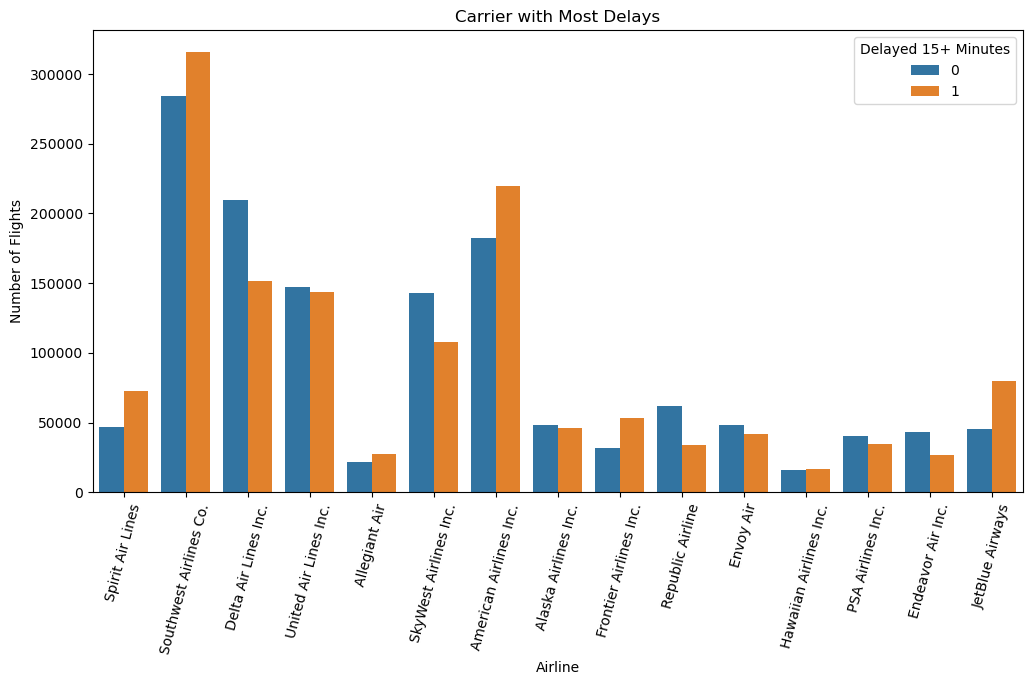

In [24]:
# Visualize the distribution of airlines with most delays 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Carrier_Name', hue=target)
plt.title('Carrier with Most Delays')
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.xticks(rotation=75)
plt.legend(title='Delayed 15+ Minutes')
plt.show()

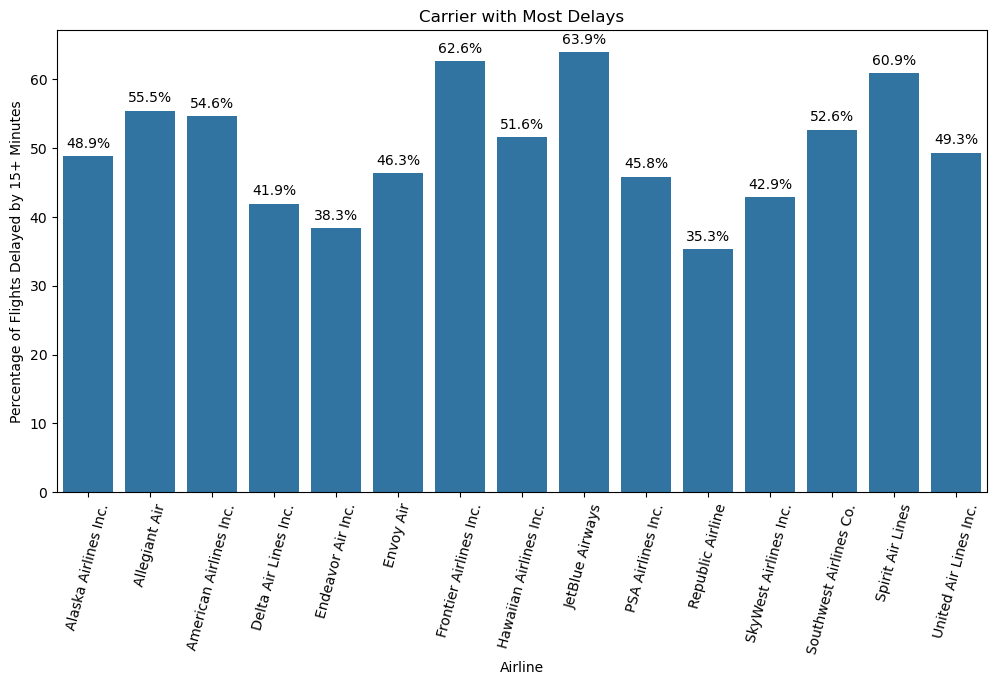

In [25]:
# Calculate the percentage of delays for each carrier
carrier_delay_percentages = df.groupby('Carrier_Name')[target].mean() * 100

# Reset index for plotting
carrier_delay_percentages = carrier_delay_percentages.reset_index()

# Plot the percentage of delays
plt.figure(figsize=(12, 6))
barplot = sns.barplot(data=carrier_delay_percentages, x='Carrier_Name', y=target)
plt.title('Carrier with Most Delays')
plt.xlabel('Airline')
plt.ylabel('Percentage of Flights Delayed by 15+ Minutes')
plt.xticks(rotation=75)

# Add percentage labels on the bars
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}%', 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 9), 
                     textcoords='offset points')

plt.show()

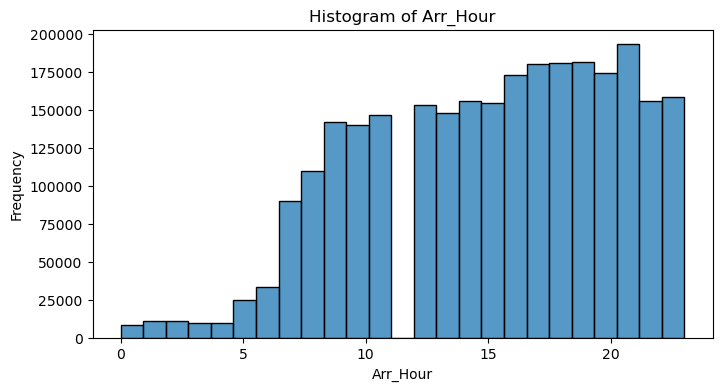

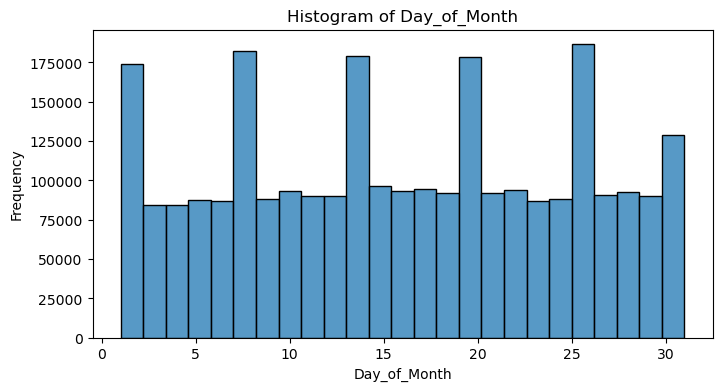

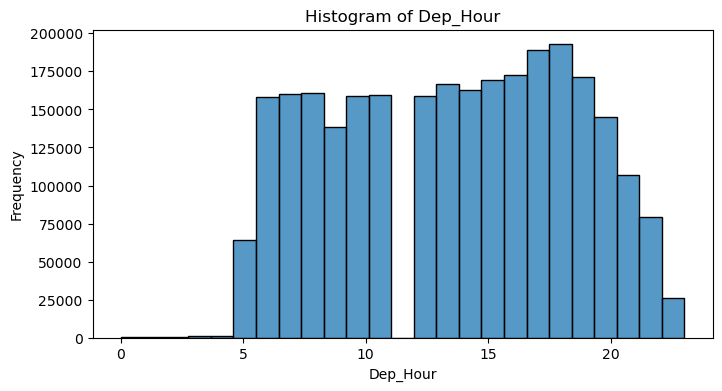

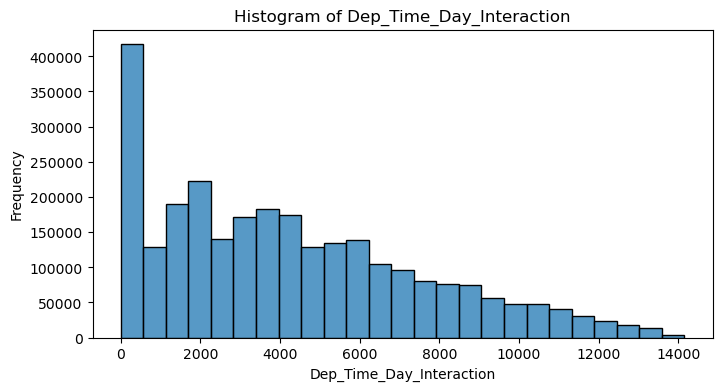

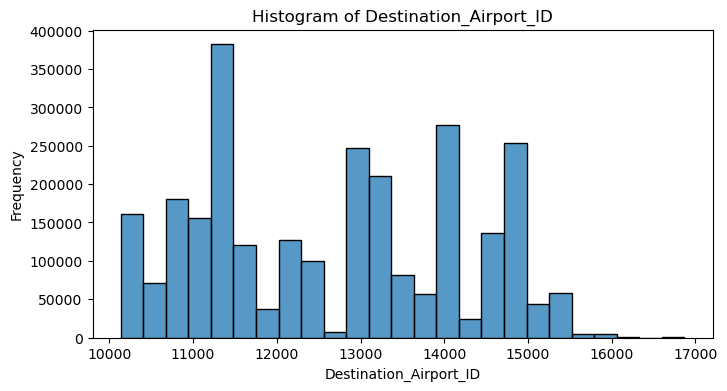

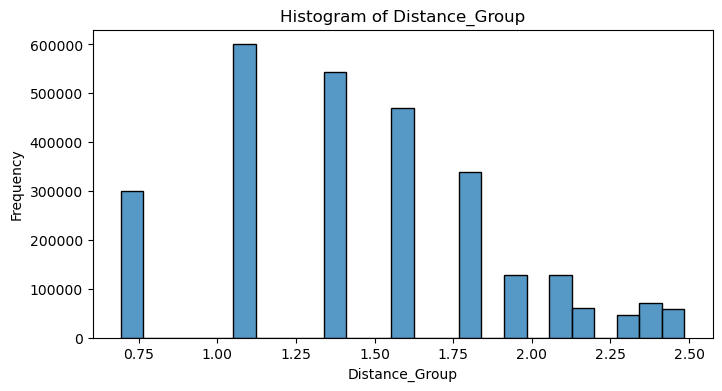

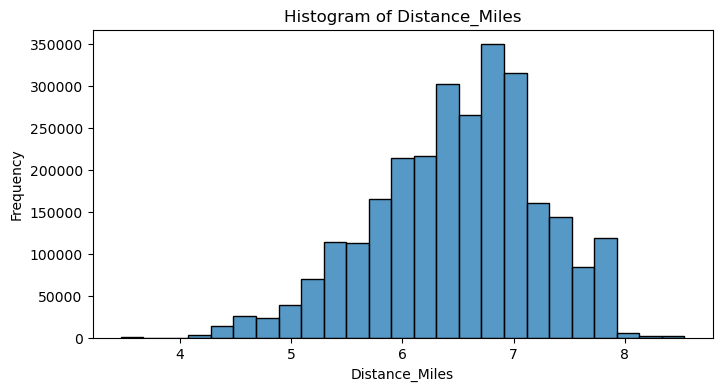

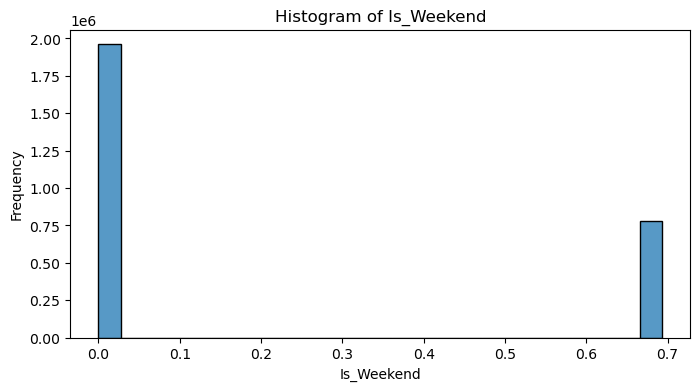

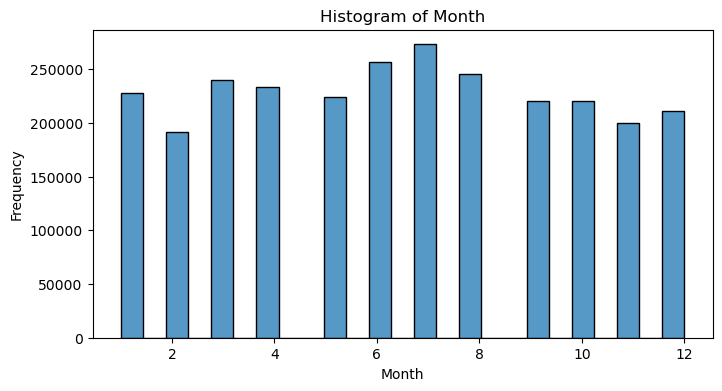

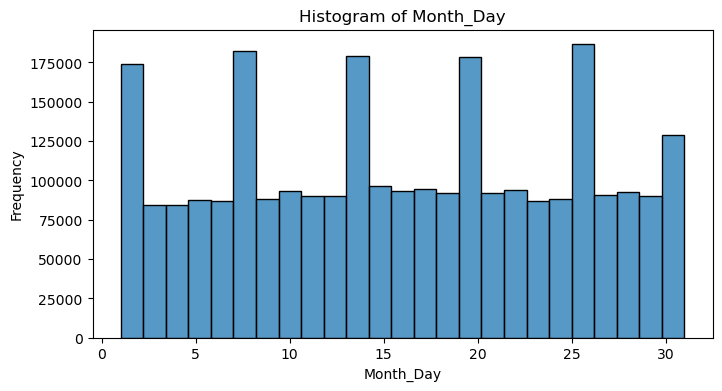

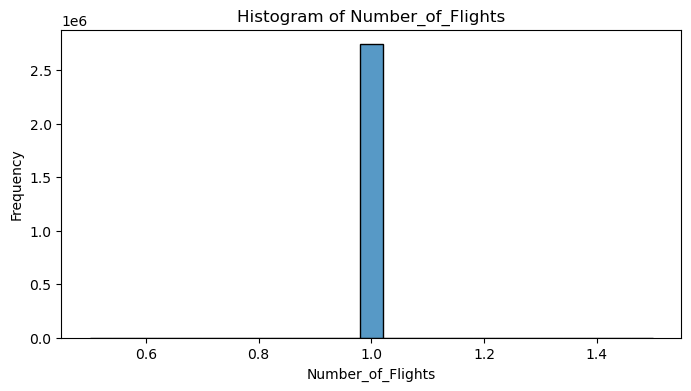

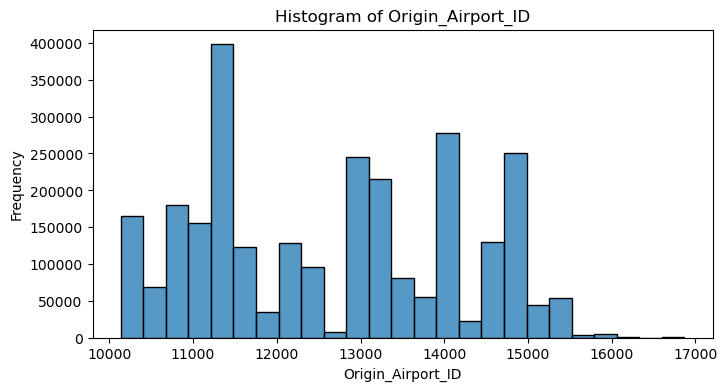

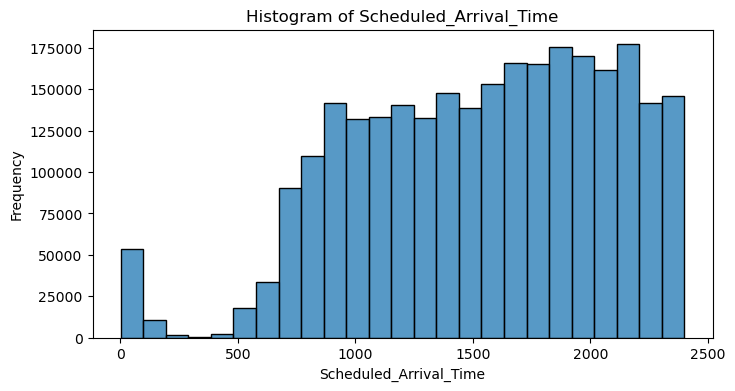

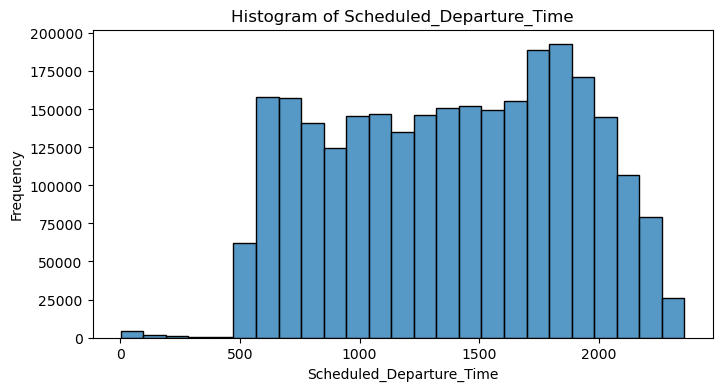

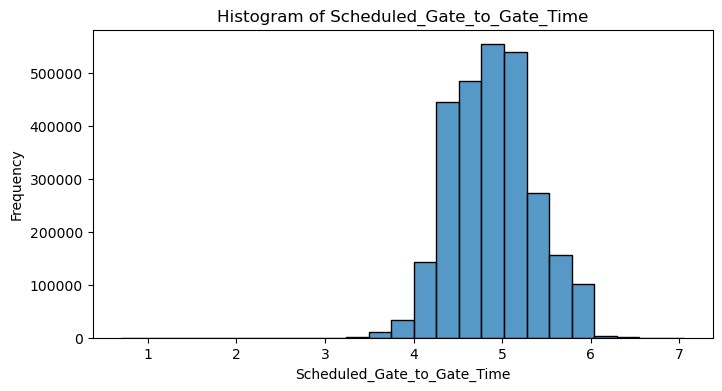

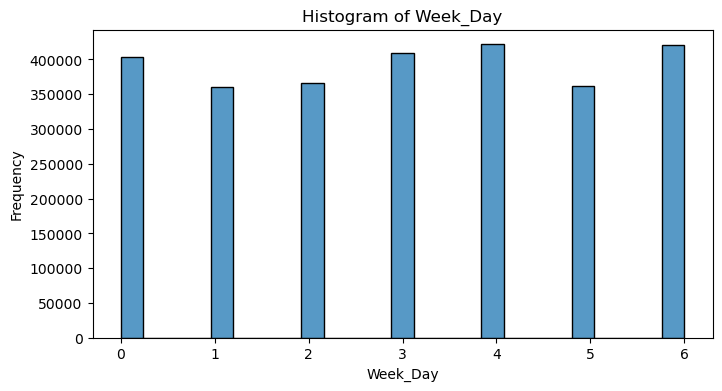

In [26]:
# Visualize the distribution of numerical features
for feature in numerical_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=False, bins=25)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

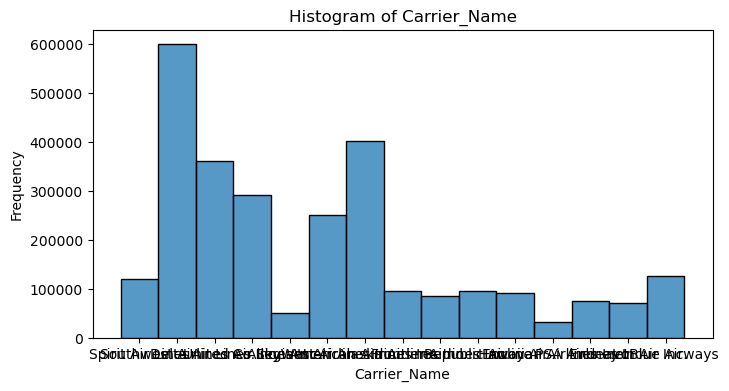

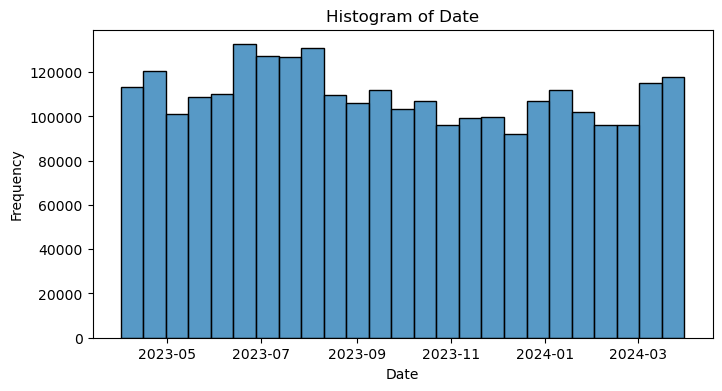

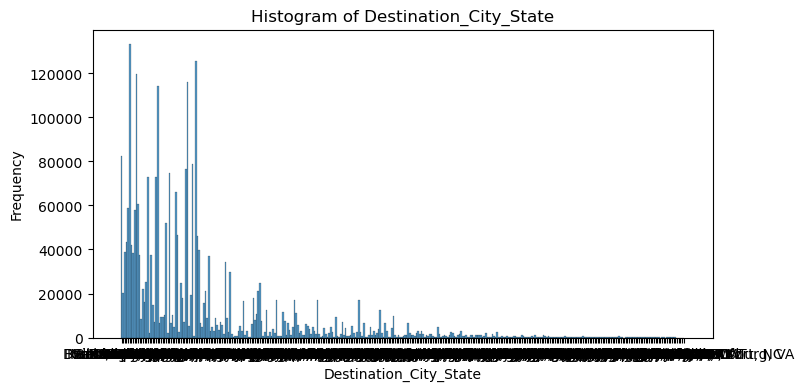

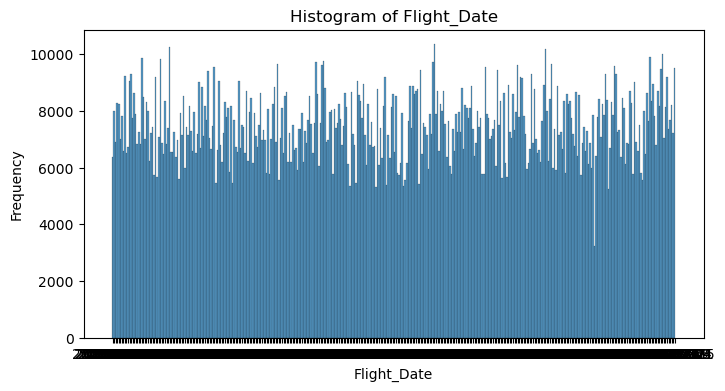

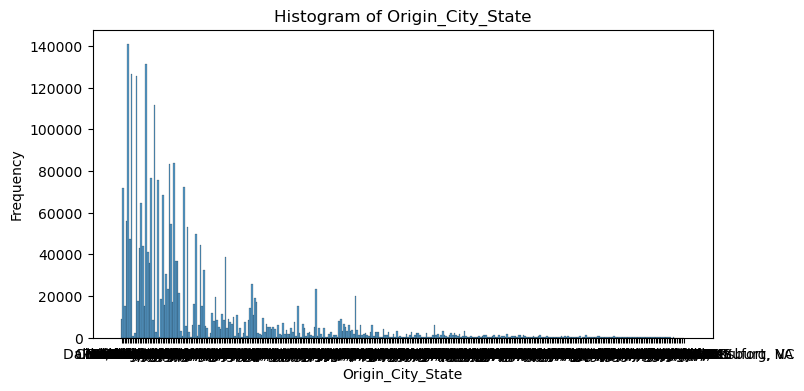

In [27]:
# Visualize the distribution of categorical features
for feature in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=False, bins=25)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

### Handling Outliers

In [29]:
# Handle Outliers (capping at the 99th percentile)

for feature in numerical_vars:
    cap_value = df[feature].quantile(0.99)
    df[feature] = df[feature].apply(lambda x: min(x, cap_value))
    # Explicitly cast the column to the original dtype
    original_dtype = df[feature].dtype
    df[feature] = df[feature].astype(original_dtype)

print("Outliers handled and dtype explicitly casted.")

Outliers handled and dtype explicitly casted.


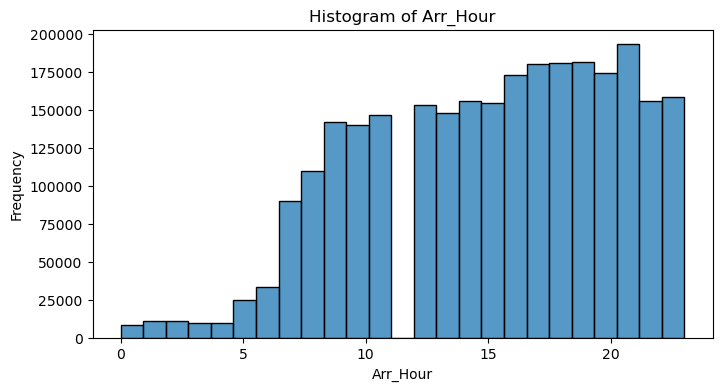

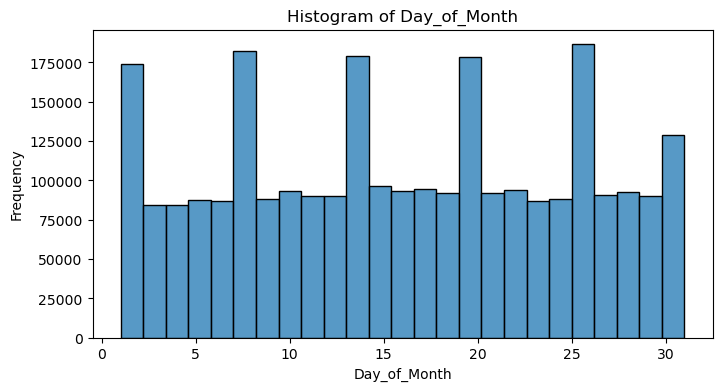

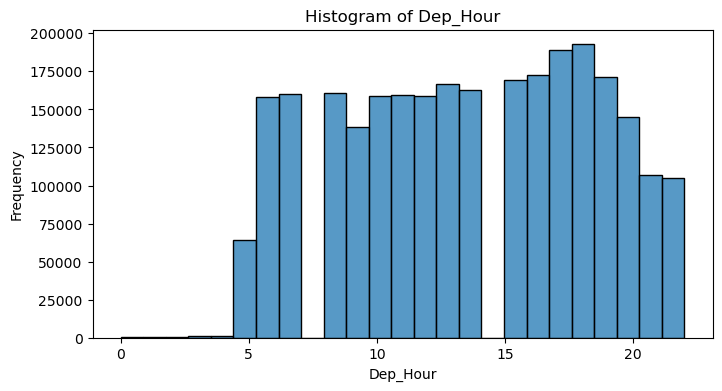

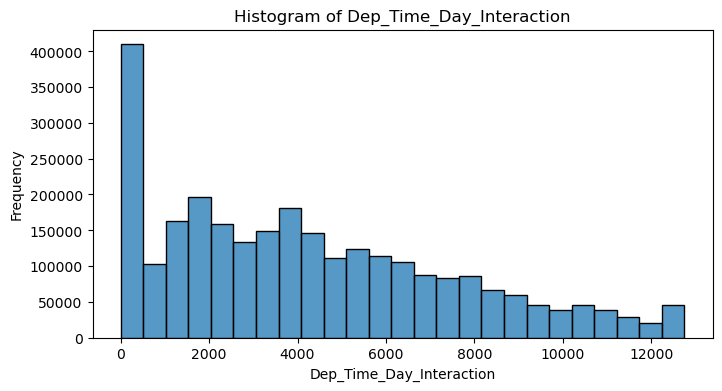

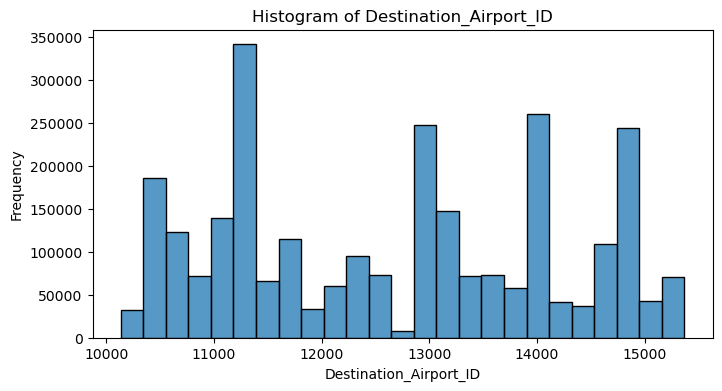

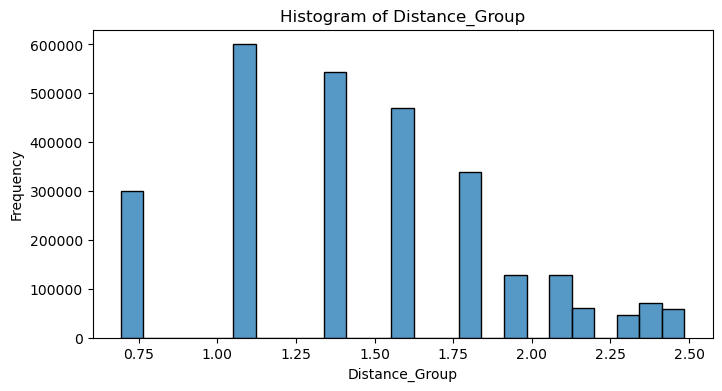

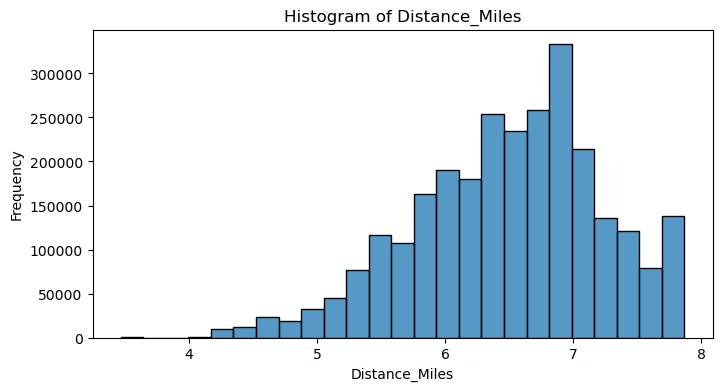

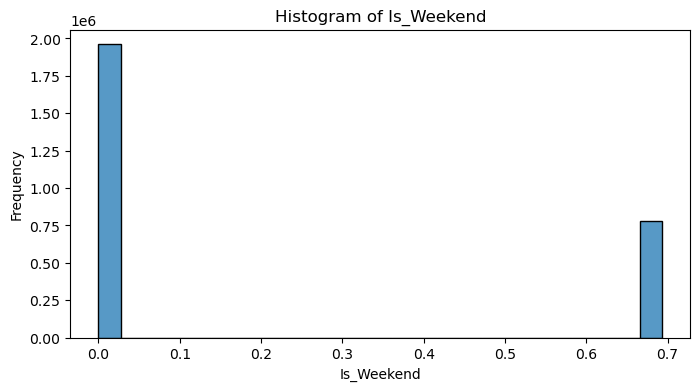

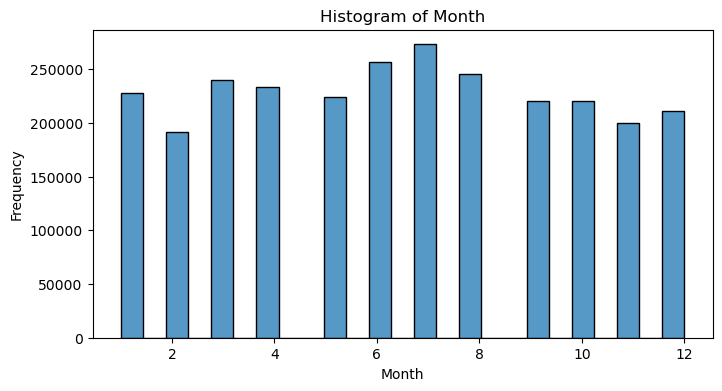

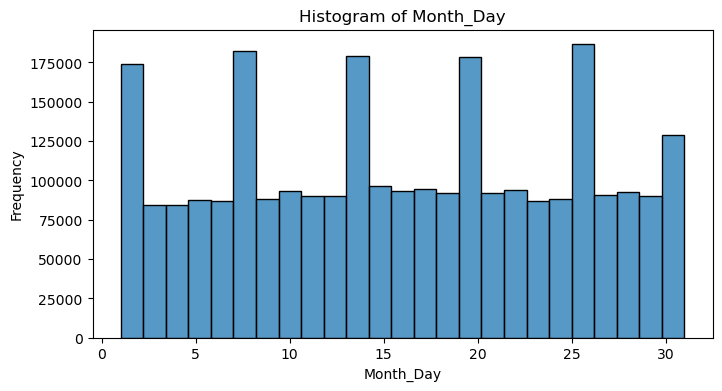

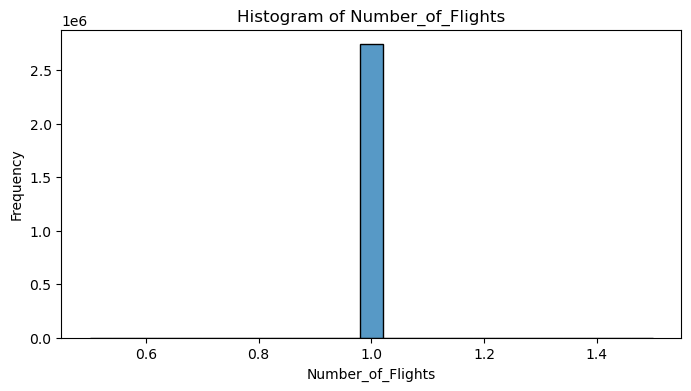

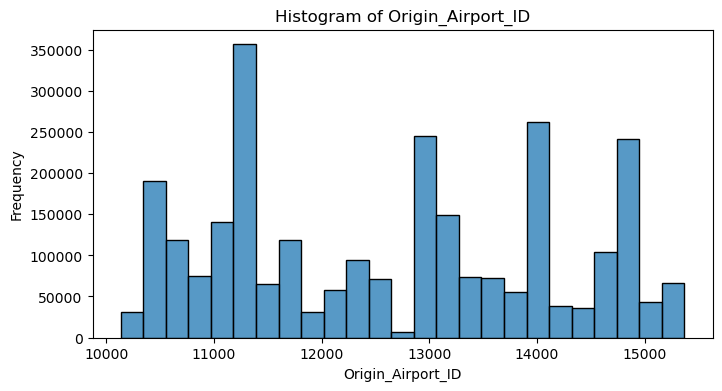

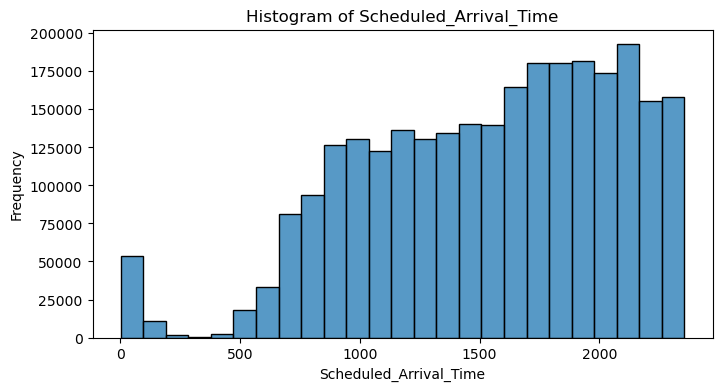

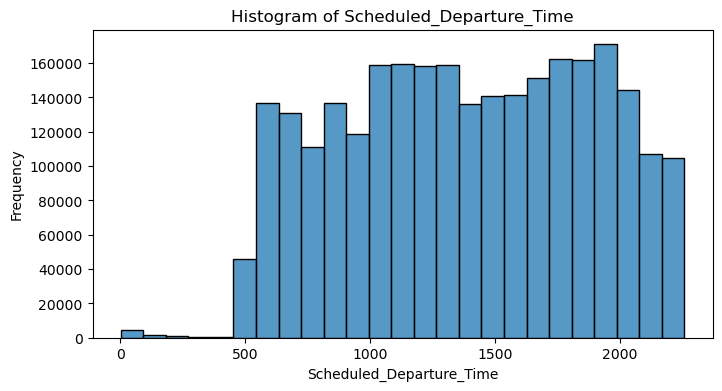

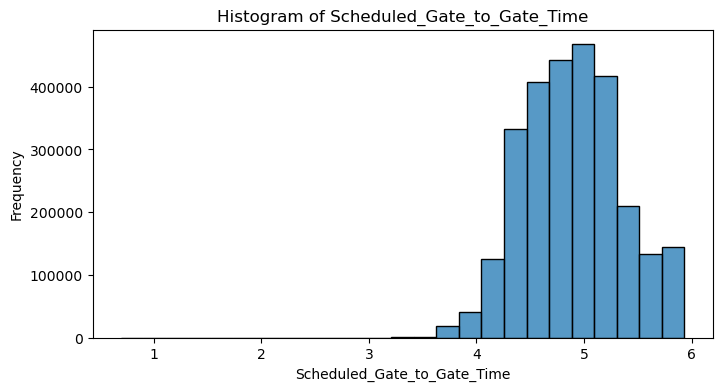

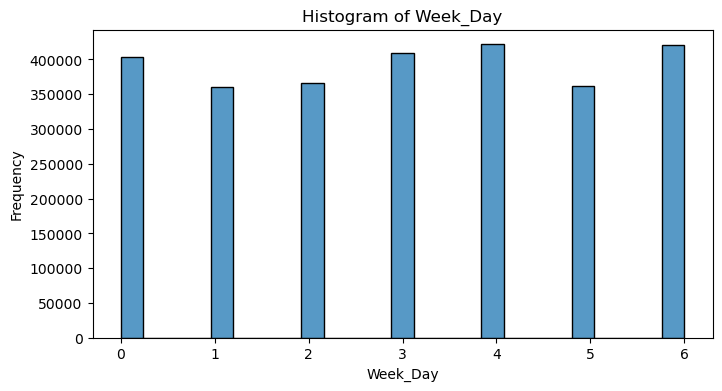

In [30]:
# Re-visualize the capped data
for feature in numerical_vars:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[feature], kde=False, bins=25)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

In [31]:
# Create a correlation matrix
correlation_features = numerical_vars + [target]
correlation_matrix = df[correlation_features].corr()

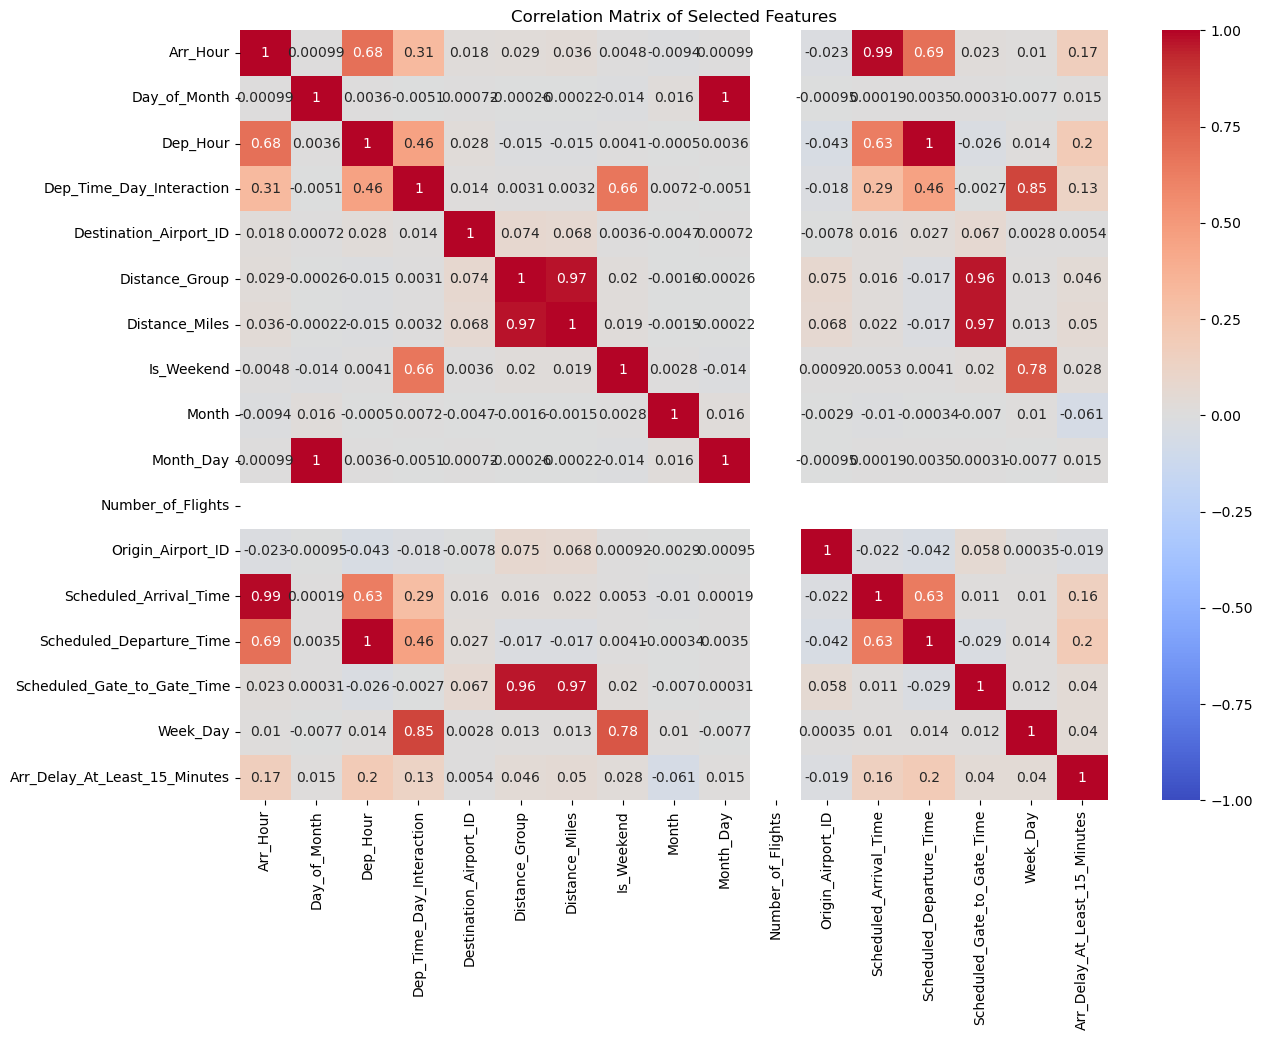

In [32]:
# Plot the correlation matrix using a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix of Selected Features')
plt.show()

## FEATURE SELECTION

In [34]:
# Feature Selection (identify and remove highly correlated features)
threshold = 0.8
highly_correlated_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            highly_correlated_pairs.append((colname_i, colname_j, correlation_matrix.iloc[i, j]))

# Print the highly correlated pairs
print("Highly correlated pairs (|correlation| > 0.8):")
for pair in highly_correlated_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]}")

Highly correlated pairs (|correlation| > 0.8):
Distance_Miles and Distance_Group: 0.9713690161655656
Month_Day and Day_of_Month: 1.0
Scheduled_Arrival_Time and Arr_Hour: 0.9858460245349753
Scheduled_Departure_Time and Dep_Hour: 0.9959205477163079
Scheduled_Gate_to_Gate_Time and Distance_Group: 0.9634372599823842
Scheduled_Gate_to_Gate_Time and Distance_Miles: 0.966447471032804
Week_Day and Dep_Time_Day_Interaction: 0.8454043770736503


In [35]:
# List of features to remove 
features_to_remove = ['Distance_Miles', 'Day_of_Month', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Week_Day'] 

# Remove highly correlated features from the feature set
selected_features = [col for col in numerical_vars if col not in features_to_remove]

print("Selected features after removing highly correlated features:")
print(selected_features)

# Update DataFrame with the selected features
X = df[selected_features]

Selected features after removing highly correlated features:
['Arr_Hour', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Destination_Airport_ID', 'Distance_Group', 'Is_Weekend', 'Month', 'Month_Day', 'Number_of_Flights', 'Origin_Airport_ID', 'Scheduled_Gate_to_Gate_Time']


In [36]:
# Drop irrelevant columns to optimize processing
updated_numerical_vars = [
    'Arr_Hour', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Distance_Miles', 'Is_Weekend',
    'Month', 'Number_of_Flights', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time',
    'Scheduled_Gate_to_Gate_Time', 'Week_Day'
]

updated_categorical_vars = ['Carrier_Name', 'Destination_City_State', 'Origin_City_State']

In [37]:
# Verify the columns in numerical_vars and categorical_vars exist in the DataFrame
print("Numerical Variables:", updated_numerical_vars)
print("Categorical Variables:", updated_categorical_vars)

# Ensure the columns are in the DataFrame
missing_numerical = [col for col in updated_numerical_vars if col not in df.columns]
missing_categorical = [col for col in updated_categorical_vars if col not in df.columns]

print("Missing numerical columns:", missing_numerical)
print("Missing categorical columns:", missing_categorical)

Numerical Variables: ['Arr_Hour', 'Dep_Hour', 'Dep_Time_Day_Interaction', 'Distance_Miles', 'Is_Weekend', 'Month', 'Number_of_Flights', 'Scheduled_Arrival_Time', 'Scheduled_Departure_Time', 'Scheduled_Gate_to_Gate_Time', 'Week_Day']
Categorical Variables: ['Carrier_Name', 'Destination_City_State', 'Origin_City_State']
Missing numerical columns: []
Missing categorical columns: []


In [38]:
# Ensure that X includes the updated numerical and categorical variables
X = df[updated_numerical_vars + updated_categorical_vars]
y = df[target]

# Creating new dataset for modelling
df_selected_features = pd.concat([X, y], axis=1)

# Save the selected features along with the target variable to a CSV file
df_selected_features.to_csv('selected_features.csv', index=False)

# Print the head of the combined dataframe to check
df_selected_features.head()

,Arr_Hour,Dep_Hour,Dep_Time_Day_Interaction,Distance_Miles,Is_Weekend,Month,Number_of_Flights,Scheduled_Arrival_Time,Scheduled_Departure_Time,Scheduled_Gate_to_Gate_Time,Week_Day,Carrier_Name,Destination_City_State,Origin_City_State,Arr_Delay_At_Least_15_Minutes
0,7,6.0,3000.0,7.393263,0.693147,5,1,703.0,600.0,5.497168,5,Spirit Air Lines,"Las Vegas, NV","Louisville, KY",0
1,12,21.0,0.0,6.951772,0.000000,5,1,125.0,2100.0,4.983607,0,Southwest Airlines Co.,"Kansas City, MO","Phoenix, AZ",0
2,14,13.0,2610.0,6.066108,0.000000,5,1,1430.0,1305.0,4.454347,2,Southwest Airlines Co.,"Baltimore, MD","Cincinnati, OH",0
3,17,15.0,9030.0,7.025538,0.693147,6,1,1720.0,1505.0,5.278115,6,Delta Air Lines Inc.,"Minneapolis, MN","Boston, MA",0
4,10,21.0,8508.0,6.766192,0.000000,6,1,100.0,2127.0,5.036953,4,United Air Lines Inc.,"Boston, MA","Chicago, IL",0
